In [55]:
import keras
import numpy as np

from keras.datasets import fashion_mnist
from keras.utils import np_utils

from keras.layers import MaxPooling2D, Dropout, Dense, Flatten, Activation, Conv2D, Input, concatenate, Lambda
from keras.models import Model
from keras.losses import categorical_crossentropy, mae, kullback_leibler_divergence
from keras.metrics import categorical_accuracy
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam, Adamax, SGD

import matplotlib.pyplot as plt

### Loading data - FASHION MNIST 

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# one hot encoding
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

print("Shape training set: ", X_train.shape)
print("Shape test set: ", X_test.shape)

Shape training set:  (60000, 28, 28, 1)
Shape test set:  (10000, 28, 28, 1)


In [219]:
NUMBER_CLASSES = len(np.unique(y_train))
EPOCHS_T = 20
EPOCHS_S = 20
BATCH_SIZE = 128

### Define TEACHER

In [5]:
def teacher_model(input_shape,  number_classes, nb_filters=64, kernel_size=(3,3), pool_size=(2,2)):
    
    image_input = Input(shape=input_shape, dtype='float32', name='input')
    
    lyr = Conv2D(nb_filters//2, kernel_size=kernel_size, activation='relu', padding='same')(image_input) # nb_filters=32, kernel (3, 3)
    lyr = Conv2D(nb_filters, kernel_size=kernel_size, activation='relu', padding='same')(lyr)
    lyr = MaxPooling2D(pool_size=pool_size)(lyr)
    
    lyr = Dropout(0.25)(lyr)
    
    lyr = Conv2D(nb_filters*2, kernel_size=kernel_size, activation='relu', padding='same')(lyr)
    lyr = MaxPooling2D(pool_size=pool_size)(lyr)
    lyr = Dropout(0.5)(lyr)
    
    lyr = Flatten()(lyr)
    lyr = Dense(128, activation='relu')(lyr)
    lyr = Dropout(0.525)(lyr)
    
    lyr = Dense(number_classes)(lyr)
    output = Activation('softmax')(lyr)
    
    model = Model(
        inputs=[image_input], 
        outputs=[output]
    )
    
    return model

### Define STUDENT

In [6]:
def dense_student_model(input_shape, number_classes, temp=TEMP, nb_units=32):
    image_input = Input(shape=input_shape, dtype='float32', name='input')
    
    lyr = Flatten()(image_input)
    lyr = Dense(nb_units, activation='relu')(lyr)
    lyr = Dropout(0.2)(lyr)
    
    lyr = Dense(number_classes)(lyr)
    probs = Activation('softmax')(lyr)

    # softed probabilities at raised temperature
    logits_T = Lambda(lambda x: x / temp)(lyr)
    probs_T = Activation('softmax')(logits_T)

    output = concatenate([probs, probs_T])
    
    model = Model(
        inputs=[image_input], 
        outputs=[output]
    )
    
    return model

In [7]:
def conv_student_model(input_shape, number_classes, temp=TEMP, nb_filters=64, kernel_size=(3,3), pooling_size=(2,2)):
    image_input = Input(shape=input_shape, dtype='float32', name='input')
    
    lyr = Conv2D(nb_filters//2, kernel_size=kernel_size, activation='relu')(image_input) # nb_filters=32, kernel (3, 3)
    # lyr = Conv2D(nb_filters, kernel_size=kernel_size, activation='relu')(lyr)
    lyr = MaxPooling2D(pool_size=pooling_size)(lyr)
    
    lyr = Dropout(0.5)(lyr)
    
    lyr = Flatten()(lyr)
    lyr = Dense(number_classes)(lyr)
    probs = Activation('softmax')(lyr)
    
    # softed probabilities at raised temperature
    logits_T = Lambda(lambda x: x / temp)(lyr)
    probs_T = Activation('softmax')(logits_T)

    output = concatenate([probs, probs_T])
    
    model = Model(
        inputs=[image_input], 
        outputs=[output]
    )
    
    return model

### Define similar Student model for comparison outside of knowledge distillation

In [169]:
def simple_conv_model(input_shape, number_classes, nb_filters=64, kernel_size=(3,3), pooling_size=(2,2)):
    
    image_input = Input(shape=(28,28,1), dtype='float32', name='input')
    
    lyr = Conv2D(nb_filters//2, kernel_size=kernel_size, activation='relu')(image_input) # nb_filters=32, kernel (3, 3)
    lyr = MaxPooling2D(pool_size=pooling_size)(lyr)
    lyr = Dropout(0.25)(lyr)
    
    lyr = Flatten()(lyr)
    lyr = Dense(number_classes)(lyr)
    output = Activation('softmax')(lyr)
   
    model = Model(
        inputs=[image_input], 
        outputs=[output]
    )
    
    return model

### Teacher model prepared

In [9]:
teacher = teacher_model(X_train.shape[1:], number_classes=NUMBER_CLASSES)
teacher.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
_____________________________________________________

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
teacher.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # 'adadelta'

In [12]:
# Train the teacher model using normal softmax
teacher.fit(X_train, Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS_T,
          verbose=1,
          validation_data=(X_test, Y_test),
           callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 172s 3ms/step - loss: 2.7137 - accuracy: 0.6703 - val_loss: 0.3912 - val_accuracy: 0.8594
Epoch 2/30


C:\Users\ivasc\Anaconda3\envs\tf_home\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


60000/60000 [==============================] - 185s 3ms/step - loss: 0.4616 - accuracy: 0.8339 - val_loss: 0.3273 - val_accuracy: 0.8803
Epoch 3/30
60000/60000 [==============================] - 177s 3ms/step - loss: 0.3938 - accuracy: 0.8566 - val_loss: 0.2986 - val_accuracy: 0.8909
Epoch 4/30
60000/60000 [==============================] - 195s 3ms/step - loss: 0.3659 - accuracy: 0.8677 - val_loss: 0.2886 - val_accuracy: 0.8941
Epoch 5/30
60000/60000 [==============================] - 185s 3ms/step - loss: 0.3394 - accuracy: 0.8762 - val_loss: 0.2770 - val_accuracy: 0.9021
Epoch 6/30
60000/60000 [==============================] - 175s 3ms/step - loss: 0.3229 - accuracy: 0.8832 - val_loss: 0.2692 - val_accuracy: 0.8992
Epoch 7/30
60000/60000 [==============================] - 176s 3ms/step - loss: 0.3141 - accuracy: 0.8846 - val_loss: 0.2554 - val_accuracy: 0.9056
Epoch 8/30
60000/60000 [==============================] - 178s 3ms/step - loss: 0.3044 - accuracy: 0.8890 - val_loss: 0.252

### Collect logits from TEACHER

In [13]:
# Collect the logits from the previous layer output
teacher_before_softmax = Model(teacher.input, teacher.get_layer('dense_2').output)

In [14]:
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

### Finding temprature

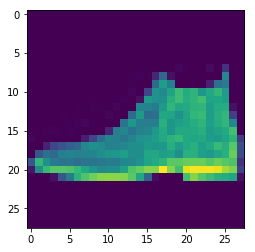

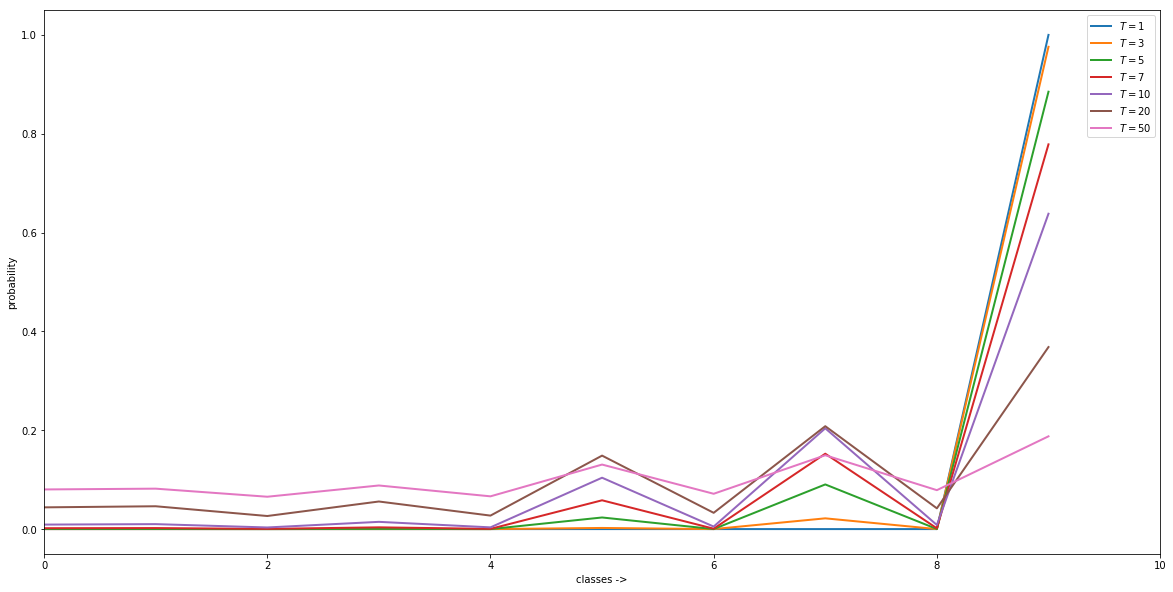

In [19]:
intermediate_output = teacher_before_softmax.predict(X_test[0].reshape(1,28,28,1))

pixels = X_test[0] #  true label: 9
pixels = pixels.reshape((28, 28))
plt.imshow(pixels)
plt.show()

# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize=(20, 10));

temperature = [1, 3, 5, 7, 10, 20, 50]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=2);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 10]);
plt.show()

In [220]:
TEMP = 7

### Create soft targets for student to be trained on

In [15]:
teacher_logits_train = teacher_before_softmax.predict(X_train)
teacher_logits_test = teacher_before_softmax.predict(X_test)

temp_logits_train = teacher_logits_train / TEMP
temp_logits_test = teacher_logits_test / TEMP

# soft labels
soft_y_train = softmax(temp_logits_train)
soft_y_test = softmax(temp_logits_test)

# concatenate soft to hard labels
Y_train_new = np.concatenate([Y_train, soft_y_train], axis=1)
Y_test_new =  np.concatenate([Y_test, soft_y_test], axis =1)

In [16]:
print("New shape training set: ", Y_train_new.shape)
print("New shape test set: ", Y_test_new.shape)

New shape training set:  (60000, 20)
New shape test set:  (10000, 20)


### Loss function for STUDENT

In [209]:
def knowledge_distillation_loss(y_true, y_pred, alpha, number_classes=NUMBER_CLASSES, temp=TEMP):
    hard_true_y, soft_true_y = y_true[:,:number_classes], y_true[:,number_classes:]
    hard_pred_y, soft_pred_y = y_pred[:,:number_classes], y_pred[:,number_classes:]
    
    loss = (1-alpha)*categorical_crossentropy(hard_true_y, hard_pred_y) + alpha*temp*temp*kullback_leibler_divergence(soft_true_y, soft_pred_y)
    
    #(1-alpha)*categorical_crossentropy(hard_true_y, hard_pred_y) + alpha*temp*temp*kullback_leibler_divergence(soft_true_y, soft_pred_y)
    #alpha*categorical_crossentropy(hard_true_y, hard_pred_y) + mae(soft_true_y, soft_pred_y) 
    #alpha*categorical_crossentropy(hard_true_y, hard_pred_y) + categorical_crossentropy(soft_true_y, soft_pred_y)
    
    return loss

In [23]:
# selecting right info for accuracy
def accuracy(y_true, y_pred, number_classes=NUMBER_CLASSES):
    hard_true_y = y_true[:,:number_classes]
    hard_pred_y = y_pred[:,:number_classes]
    
    return categorical_accuracy(hard_true_y, hard_pred_y)

In [84]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)


### Training student

In [216]:
# conv student
conv_student = conv_student_model(X_train.shape[1:], number_classes=NUMBER_CLASSES)
conv_student.summary()

Model: "model_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 26, 26, 32)   320         input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 13, 13, 32)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
dropout_78 (Dropout)            (None, 13, 13, 32)   0           max_pooling2d_19[0][0]           
___________________________________________________________________________________________

In [217]:
conv_student.compile(
    optimizer='adam',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    metrics=[accuracy])

conv_student.fit(X_train, Y_train_new,
          batch_size=128, #BATCH_SIZE,
          epochs=20, #EPOCHS_S,
          verbose=1,
          validation_data=(X_test, Y_test_new))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 21s 358us/step - loss: 4.4134 - accuracy: 0.6814 - val_loss: 2.3431 - val_accuracy: 0.8168
Epoch 2/20
60000/60000 [==============================] - 22s 365us/step - loss: 1.1132 - accuracy: 0.8267 - val_loss: 0.3874 - val_accuracy: 0.8514
Epoch 3/20
60000/60000 [==============================] - 22s 367us/step - loss: 0.3548 - accuracy: 0.8628 - val_loss: 0.3419 - val_accuracy: 0.8686
Epoch 4/20
60000/60000 [==============================] - 22s 370us/step - loss: 0.3084 - accuracy: 0.8776 - val_loss: 0.3327 - val_accuracy: 0.8709
Epoch 5/20
60000/60000 [==============================] - 22s 372us/step - loss: 0.2859 - accuracy: 0.8857 - val_loss: 0.3274 - val_accuracy: 0.8759
Epoch 6/20
60000/60000 [==============================] - 26s 432us/step - loss: 0.2685 - accuracy: 0.8925 - val_loss: 0.3142 - val_accuracy: 0.8805
Epoch 7/20
60000/60000 [==============================] 

In [218]:
conv_student.evaluate(X_test, Y_test_new)

10000/10000 [==============================] - 1s 107us/step


[0.33435497429966926, 0.8883000016212463]

### Testing a model simple as Student model to compare

##### small difference 1-2% roughly

In [199]:
#print(X_train.shape[1:])
simple_conv = simple_conv_model(X_train.shape[1:], number_classes=NUMBER_CLASSES)
simple_conv.summary()

Model: "model_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_66 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_125 (Dense)            (None, 10)                54090     
_________________________________________________________________
activation_72 (Activation)   (None, 10)                0  

In [200]:
optimizer = Adam()
simple_conv.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
simple_conv.fit(X_train, Y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 23s 379us/step - loss: 7.2751 - accuracy: 0.5436 - val_loss: 6.8495 - val_accuracy: 0.5702
Epoch 2/10
60000/60000 [==============================] - 19s 313us/step - loss: 6.7394 - accuracy: 0.5778 - val_loss: 6.7248 - val_accuracy: 0.5780
Epoch 3/10
60000/60000 [==============================] - 19s 318us/step - loss: 3.5828 - accuracy: 0.7051 - val_loss: 0.4566 - val_accuracy: 0.8456
Epoch 4/10
60000/60000 [==============================] - 20s 340us/step - loss: 0.4132 - accuracy: 0.8572 - val_loss: 0.3989 - val_accuracy: 0.8634
Epoch 5/10
60000/60000 [==============================] - 23s 377us/step - loss: 0.3601 - accuracy: 0.8727 - val_loss: 0.3758 - val_accuracy: 0.8719
Epoch 6/10
60000/60000 [==============================] - 21s 349us/step - loss: 0.3328 - accuracy: 0.8806 - val_loss: 0.3704 - val_accuracy: 0.8704
Epoch 7/10
60000/60000 [==============================] 

In [201]:
simple_conv.evaluate(X_test, Y_test)

10000/10000 [==============================] - 1s 130us/step


[0.3592347024679184, 0.8758000135421753]

### No parameters models

In [32]:
print("Teacher parameters: %d" % teacher.count_params())
print("Student dense parameters: %d" % simple_student.count_params())
print("Student conv parameters: %d" % conv_student.count_params()) # 16 times less params
# print("Simple conv parameters: %d" % simple_conv.count_params())

Teacher parameters: 896906
Student dense parameters: 25450
Student conv parameters: 54410
